# Stage 6: Comprehensive Data Preprocessing
- Missing data handling (MCAR/MAR/MNAR, visualization, fill/drop strategies)
- Filtering and threshold-based row drops
- Type corrections (currency, dates, categorical)
- Scaling/normalization (MinMax, StandardScaler)
- Reusable functions for reproducibility and workflow


In [2]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import missingno as msno
import os 
from dotenv import load_dotenv

In [4]:


# Step 1: Find project root dynamically (look for folder containing .env)
current_dir = os.getcwd()
project_root = current_dir

while not os.path.isfile(os.path.join(project_root, ".env")):
    # Go one directory up
    parent_dir = os.path.abspath(os.path.join(project_root, ".."))
    if parent_dir == project_root:
        raise FileNotFoundError(".env file not found in any parent directory")
    project_root = parent_dir

# Step 2: Load .env from project root
load_dotenv(os.path.join(project_root, ".env"))

True

## Load Dataset

In [5]:
# Load instructor CSV
df = pd.read_csv(os.getenv("DATA_DIR_RAW") + "/USD_ZAR_2025_07.csv")
df.head()

,exchange,date_time,bid,ask
0,USD/ZAR,20250701 00:00:00.078,17.7147,17.7272
1,USD/ZAR,20250701 00:00:00.141,17.7123,17.7338
2,USD/ZAR,20250701 00:00:00.156,17.7167,17.7267
3,USD/ZAR,20250701 00:00:00.234,17.7185,17.7267
4,USD/ZAR,20250701 00:00:00.234,17.7185,17.7272


## Inspect Missingness

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6720782 entries, 0 to 6720781
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   exchange   object 
 1   date_time  object 
 2   bid        float64
 3   ask        float64
dtypes: float64(2), object(2)
memory usage: 205.1+ MB


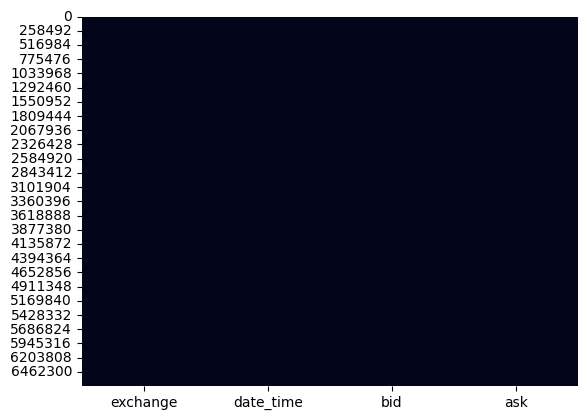

<Axes: >

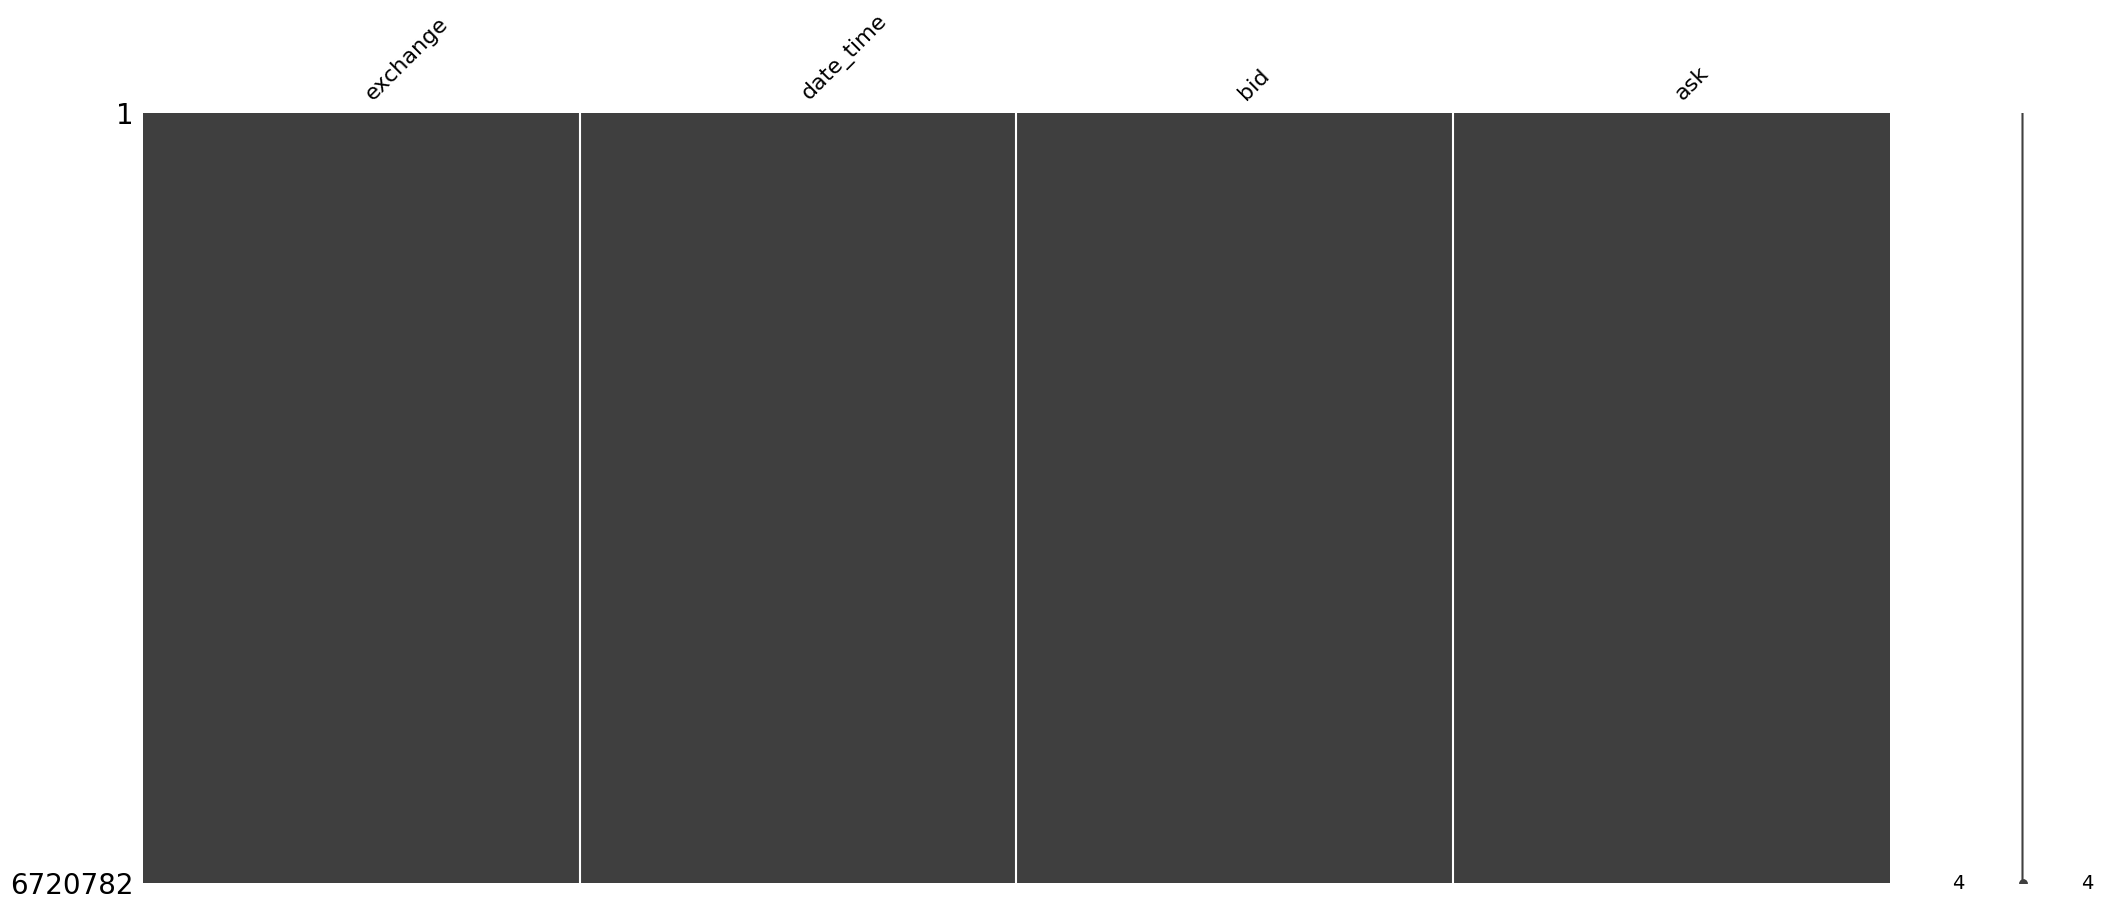

In [6]:
# Basic info and missing counts
df.info()
df.isna().sum()

# Heatmap for missing data
sns.heatmap(df.isnull(), cbar=False)
plt.show()

# missingno visualization
msno.matrix(df)

## Simulate MCAR / MAR / MNAR Missingness

In [7]:
# MCAR: random missing
df['MCAR_col'] = df['bid'].mask(np.random.rand(len(df)) < 0.1)
# MAR: missing depends on another column
df['MAR_col'] = df['bid'].mask(df['date_time'].str.split().str[0]=='20250701')
# MNAR: missing depends on its own value
df['MNAR_col'] = df['bid'].mask(df['bid']>50)

## Handling Missing Values

In [8]:
# Fill missing with median
df['bid'] = df['bid'].fillna(df['bid'].median())

# Drop rows with missing MCAR
df.dropna(subset=['MCAR_col'], inplace=True)

# Alternative strategies
df_fill_mean = df.fillna(df.mean(numeric_only=True))
df_fill_median = df.fillna(df.median(numeric_only=True))
df_fill_ffill = df.fillna(method='ffill')

# Threshold-based row drop example
df_drop_thresh = df.dropna(thresh=int(0.5*df.shape[1]))

/var/folders/bv/q79dnkgx31j62rs4kyg5rwpm0000gn/T/ipykernel_12022/847768859.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_fill_ffill = df.fillna(method='ffill')


## Type Corrections

In [9]:
# Currency string to numeric
if 'price' in df.columns:
    df['price'] = df['price'].str.replace('$','').astype(float)

# Convert string to datetime
if 'date_time' in df.columns:
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

# Standardize categorical column
if 'category' in df.columns:
    df['category'] = df['category'].str.lower().astype('category')

In [ ]:


# print("Demo DataFrame:")
print(df)

# Show column types
print("\nColumn types:")
print(df.dtypes)


# Select numeric columns (generic)
numeric_cols = df.select_dtypes(include='number').columns
print("\nNumeric columns (generic):", list(numeric_cols))

# Select object columns (generic)
object_cols = df.select_dtypes(include='object').columns
print("Object columns (generic):", list(object_cols))


        exchange               date_time      bid      ask  MCAR_col  MAR_col  \
0        USD/ZAR 2025-07-01 00:00:00.078  17.7147  17.7272   17.7147      NaN   
1        USD/ZAR 2025-07-01 00:00:00.141  17.7123  17.7338   17.7123      NaN   
3        USD/ZAR 2025-07-01 00:00:00.234  17.7185  17.7267   17.7185      NaN   
4        USD/ZAR 2025-07-01 00:00:00.234  17.7185  17.7272   17.7185      NaN   
5        USD/ZAR 2025-07-01 00:00:00.313  17.7139  17.7336   17.7139      NaN   
...          ...                     ...      ...      ...       ...      ...   
6720777  USD/ZAR 2025-07-31 23:59:20.574  18.2101  18.2252   18.2101  18.2101   
6720778  USD/ZAR 2025-07-31 23:59:37.542  18.2065  18.2308   18.2065  18.2065   
6720779  USD/ZAR 2025-07-31 23:59:39.120  18.2101  18.2252   18.2101  18.2101   
6720780  USD/ZAR 2025-07-31 23:59:40.713  18.2101  18.2252   18.2101  18.2101   
6720781  USD/ZAR 2025-07-31 23:59:51.306  18.2101  18.2252   18.2101  18.2101   

         MNAR_col  
0      

## Scaling and Normalization

In [11]:
# MinMax scaling for numeric_col
scaler = MinMaxScaler()
df['numeric_scaled_bid'] = scaler.fit_transform(df[['bid']])

df['numeric_scaled_ask'] = scaler.fit_transform(df[['ask']])
# StandardScaler
standardizer = StandardScaler()
df['numeric_standard_bid'] = standardizer.fit_transform(df[['bid']])

df['numeric_standard_ask'] = standardizer.fit_transform(df[['ask']])


## Reusable Functions for Cleaning

In [12]:
def fill_missing_median(df, columns=None):
    df_copy = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=np.number).columns
    for col in columns:
        df_copy[col] = df_copy[col].fillna(df_copy[col].median())
    return df_copy

def drop_missing(df, columns=None, threshold=None):
    df_copy = df.copy()
    if columns is not None:
        return df_copy.dropna(subset=columns)
    if threshold is not None:
        return df_copy.dropna(thresh=int(threshold*df_copy.shape[1]))
    return df_copy.dropna()

def normalize_data(df, columns=None, method='minmax'):
    df_copy = df.copy()
    if columns is None:
        columns = df_copy.select_dtypes(include=np.number).columns
    if method=='minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    df_copy[columns] = scaler.fit_transform(df_copy[columns])
    return df_copy

def correct_column_types(df):
    df_copy = df.copy()
    if 'price' in df_copy.columns:
        df_copy['price'] = df_copy['price'].str.replace('$','').astype(float)
    if 'date_str' in df_copy.columns:
        df_copy['date'] = pd.to_datetime(df_copy['date_str'], errors='coerce')
    if 'category' in df_copy.columns:
        df_copy['category'] = df_copy['category'].str.lower().astype('category')
    return df_copy

## Validation & Save Cleaned Dataset

In [13]:
# Apply reusable functions
df_cleaned = df.copy()
df_cleaned = fill_missing_median(df_cleaned)
df_cleaned = drop_missing(df_cleaned, threshold=0.5)
df_cleaned = normalize_data(df_cleaned)
df_cleaned = correct_column_types(df_cleaned)

print(df_cleaned.head())

  exchange               date_time       bid       ask  MCAR_col   MAR_col  \
0  USD/ZAR 2025-07-01 00:00:00.078  0.345623  0.306501  0.345623  0.426581   
1  USD/ZAR 2025-07-01 00:00:00.141  0.342582  0.314948  0.342582  0.426581   
3  USD/ZAR 2025-07-01 00:00:00.234  0.350437  0.305861  0.350437  0.426581   
4  USD/ZAR 2025-07-01 00:00:00.234  0.350437  0.306501  0.350437  0.426581   
5  USD/ZAR 2025-07-01 00:00:00.313  0.344609  0.314692  0.344609  0.426581   

   MNAR_col  numeric_scaled_bid  numeric_scaled_ask  numeric_standard_bid  \
0  0.345623            0.345623            0.306501              0.345623   
1  0.342582            0.342582            0.314948              0.342582   
3  0.350437            0.350437            0.305861              0.350437   
4  0.350437            0.350437            0.306501              0.350437   
5  0.344609            0.344609            0.314692              0.344609   

   numeric_standard_ask  
0              0.306501  
1              0

## Preprocessing Assumptions

When we clean and preprocess data, every choice encodes assumptions about the dataset. It's important to document these for reproducibility and stakeholder understanding.

### 1. Missing Data Handling
- Filling missing numeric values with median assumes the missingness is **MCAR or MAR** (not systematically biased).  
- Forward/backward fill assumes **temporal continuity** in time series data.  
- Dropping rows assumes the missing rows are **not critical** to analysis.  
- Imputation affects averages, distributions, and model training.

### 2. Understanding Missingness
- MCAR: safe to drop or fill, assumes randomness.  
- MAR: imputation using related features is valid.  
- MNAR: missing depends on unobserved values; may require domain knowledge.  
- Misidentifying missingness can bias results.

### 3. Filtering / Data Cleaning
- Removing negative or out-of-range values assumes they are **errors or invalid entries**.  
- Dropping columns or rows with excessive missingness assumes those data are **non-essential**.  
- Rare but valid events might be lost if thresholds are too strict.

### 4. Scaling / Normalization
- StandardScaler assumes features are roughly **normally distributed**.  
- MinMaxScaler assumes min and max values are **representative**, not extreme outliers.  
- Scaling changes interpretation of magnitudes; coefficients or distances may be affected.

### 5. Column Type Corrections
- Converting strings to numeric assumes there are **no hidden characters or formatting issues**.  
- Parsing dates assumes a **consistent date format**.  
- Categoricals assume a **finite, discrete set of values**.  
- Wrong types can break computations or modeling.

### 6. Reproducibility & Modularity
- Using modular functions assumes **future datasets follow similar structure and patterns**.  
- Documenting assumptions ensures that preprocessing is **transparent** and results are interpretable.

> **Tip:** Always communicate these assumptions to stakeholders, so they understand the limitations and decisions made during preprocessing.
